# Some dimensionality devils
> Common cases of excessively eager dimensionality reduction

- toc: true 
- author: Oriol Abril
- badges: true
- categories: [python, arviz, pymc, xarray, xarray-einstats]
- tags: [rant, recommendation]
- image: images/nb/evil_kermit_posterior_mean.jpeg
- twitter_large_image: true
- use_math: true

This blog post is a loosely connected collection of potentially bad practices that I have come accross while answering questions on discourse and reading the [PyMC examples collection](https://docs.pymc.io/projects/examples/en/latest/) or similar blog posts and case studies. They are not necessarily the worst or most dangerous practices, they might not even be the most common ones! The main relation between the cases covered here is that they are related to my work and so it is much more easy for me to notice them and to remember them.

In fact, all examples are related to "dimensionality" but not necessarly using the exact same definition for the term!

In [1]:
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.lines as mlines
import xarray as xr
import pymc as pm

rng = np.random.default_rng(5)
az.style.use("arviz-darkgrid")
plt.rcParams["font.size"] = 13

In [2]:
#hide
# use text display to keep blog fast and responsive, 
# do not execute this cell when running the code
xr.set_options(display_style="text");

## Simulated data generation

I initialize three distributions to use in the examples below. I will use 2d distributions with different shape but the same marginal means `(2, 3)` and standard deviations `(0.4, 0.3)`. 2d is clearly not high dimensional and so the effects might not be of the same magnitude as what you will encounter in your real models, but it is much more convenient for visualization purposes and already serves to illustrate my points.

To give it a feel of "MCMC output" I will generate 4000 samples per distribution in a 4 "chains" and 1000 "draws" shape. This also allows loading the data as `InferenceData` and taking advantage of ArviZ functions.

For the purposes of the blog post, only the shape of the data is relevant, so the data generation is hidden inside the toggle button below and only the plots are visible by default.

In [3]:
#collapse-hide
n_chains = 4
n_draws = 1000

a = rng.multivariate_normal([0., 0.], np.array([[1, 0.85], [0.85, 1]]), size=(n_chains, n_draws))

b = np.empty_like(a)
b[..., 0] = a[..., 0] + a[..., 1]
b[..., 1] = a[..., 0] - a[..., 1]
b[..., 1] += .1*(2*b[..., 0])**2

c = rng.multivariate_normal([0., 0.], np.array([[1., 0.], [0., 1.]]), size=(n_chains, n_draws))

def mean_std_normalize(ary):
    shape = ary.shape
    assert shape[-1] == 2
    axis = tuple(range(len(shape)-1))
    mean = ary.mean(axis=axis)
    std = ary.std(axis=axis)
    return (((ary - mean) / std) * np.array([.4, .3])) + np.array([2, 3])

a = mean_std_normalize(a)
b = mean_std_normalize(b)
c = mean_std_normalize(c)

idata = az.from_dict(
    {"a": a, "b": b, "c": c}, 
    coords={"var": ["shot", "distance"]}, 
    dims={"a": ["var"], "b": ["var"], "c": ["var"]}
)

In [4]:
idata.posterior

<xarray.Dataset>
Dimensions:  (chain: 4, draw: 1000, var: 2)
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
  * var      (var) <U8 'shot' 'distance'
Data variables:
    a        (chain, draw, var) float64 2.46 3.125 2.06 ... 2.654 1.717 2.911
    b        (chain, draw, var) float64 2.326 3.023 2.107 ... 3.093 1.792 2.799
    c        (chain, draw, var) float64 1.598 2.569 2.118 ... 3.292 2.007 2.62
Attributes:
    created_at:     2022-05-18T22:35:53.739557
    arviz_version:  0.13.0.dev0

You can now see the draws of all 3 distributions in the 2d plane to see their shape. The distributions are all 2d representing a joint posterior with variables `shot` and `distance` and I have named the distributions `a, b, c` to distinguish them throughout the blog post.

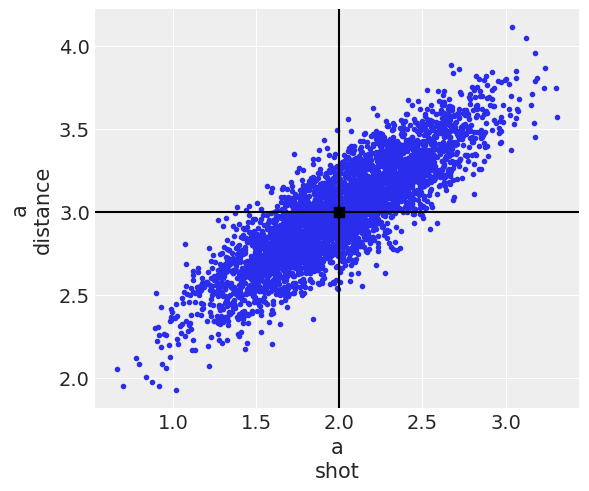

In [5]:
mpl_kwargs = {"subplot_kw": {"aspect": "equal"}}
axes = az.plot_pair(idata, var_names="a", point_estimate="mean", backend_kwargs=mpl_kwargs);

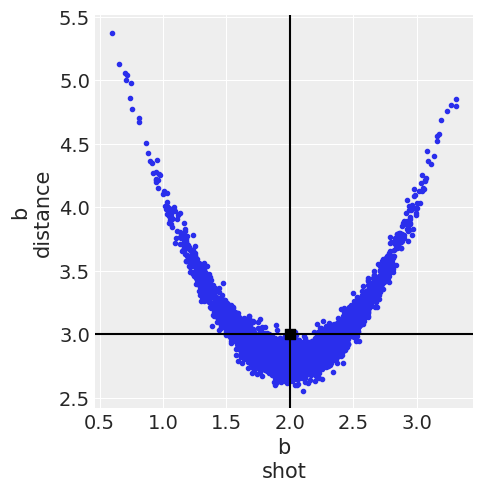

In [6]:
az.plot_pair(idata, var_names="b", point_estimate="mean", backend_kwargs=mpl_kwargs);

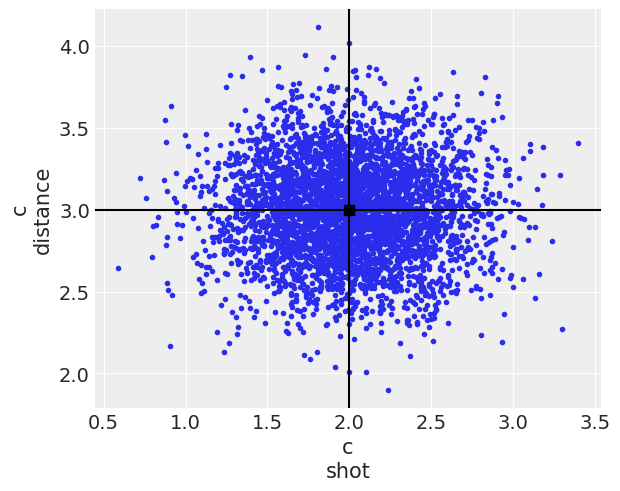

In [7]:
az.plot_pair(idata, var_names="c", point_estimate="mean", backend_kwargs=mpl_kwargs);

You can also see their marginal distributions compared below. Both `a` and `c` have the exact same marginal distributions, all normal, whereas the marginal distribution for `b` is also the same for the `shot` variable but not for the `distance` one.

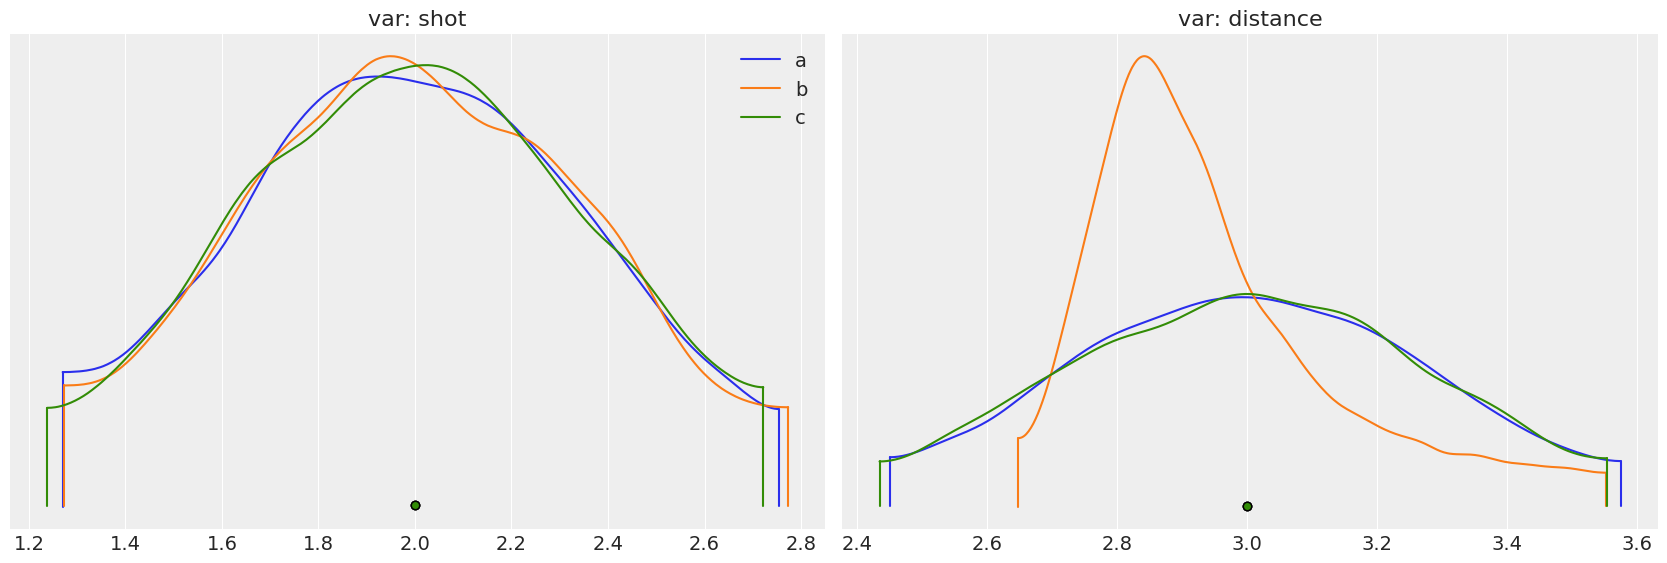

In [8]:
labeller = az.labels.mix_labellers((az.labels.NoVarLabeller, az.labels.DimCoordLabeller))
post = idata.posterior

ax = az.plot_density(
    [post[["a"]].rename(a="x"), post[["b"]].rename(b="x"), post[["c"]].rename(c="x")], 
    colors=["C0", "C1", "C2"],
    data_labels=["a", "b", "c"],
    labeller=labeller()  # remember to always pass an initialized labeller
);


Last but not least, I also double check the normalization has worked:

In [9]:
az.summary(idata, kind="stats")

,mean,sd,hdi_3%,hdi_97%
a[shot],2.0,0.4,1.268,2.755
a[distance],3.0,0.3,2.449,3.576
b[shot],2.0,0.4,1.271,2.775
b[distance],3.0,0.3,2.647,3.554
c[shot],2.0,0.4,1.236,2.723
c[distance],3.0,0.3,2.433,3.555


## Premature aggregation
Now let's get to work! It is very tempting to take the means and go with it instead of using the whole posterior, working with high dimensional arrays can be annoying or even borderline impossible unless we recurr to nested on nested loops. For the data generation to work we had to add these `[..., i]` clauses for example and it is also very common to need to reshape the data or use `[None, :]` for broadcasting to work.

And in some cases, doing that won't make any difference. If you were calculating the mean of a linear regression for example:

$$
\mu = \alpha + \beta x \\
\text{E}[\mu] = \text{E}[\alpha + \beta x] = \text{E}[\alpha] + \text{E}[\beta] x
$$

Still, very often (I might even say more often than not) this is not the case. Sometimes even with a single variable the result of the _posterior pushforward_ operations followed by the mean is not the same as the result of first taking the mean and then doing the pushforward operations.

Note: I call _posterior pushforward_ operations to deterministic operations on posterior variables as opposed to sampling from the posterior predictive which should never be done with the means alone.

In [10]:
summary = "mean"
post = idata.posterior
if summary == "mean":
    post_summary = post.mean(("chain", "draw"))
else:
    post_summary = post.median(("chain", "draw"))

In the blogpost I use only the `mean` as summary, to see how things look for the median you'll need to
rerun the notebook (you can download it or run it online clicking on the badges at the top of the notebook).

> Important: If you use the median as summary, there can be differences between aggregating before or after pushforward computation even for linear operations. Linearity of expectations is a property of the expectation (mean) function, not of the .5 quantile function!

### Pushforward computation examples

In this section I will go over some pushforward computation examples. I'll take a function that depends on two variables and apply it to each of the 3 distributions we generated. First I'll compute the result using the `post_summary` with the already averaged data and then compare it to doing the operation first and averaging later.

I will generate the same plot for each combination of function and distribution. That plot will have the following elements:

* Two vertical lines, indicating the result we get averaging before and after operating
* A box with two quantities annotated: the relative error (as a percentage) and the ratio between the difference of results and the Monte Carlo standard error (MCSE) of the result
* A histogram with the result of (block-wise) averaging after and pushforward computation and dividing all the 2000 samples into 80 blocks.

The vertical lines can probably be considered the key element of the plot, but they don't really give any information without the context provided by the other elements too. You can click to see the plotting code, but it is hidden by default as it is not necessary to follow the blog post.

In [11]:
#collapse-hide
from xarray_einstats.einops import raw_reduce

def plot_func_comparison(pushforward_func, var_name, ax=None, **kwargs):
    if ax is None:
        _, ax = plt.subplots()


    aux = post[var_name]
    post_after = pushforward_func(aux.sel(var="shot"), aux.sel(var="distance"), **kwargs)
    if summary == "mean":
        summary_after = post_after.mean(("chain", "draw"))
    else:
        summary_after = post_after.median(("chain", "draw"))
    aux = post_summary[var_name]
    summary_before = pushforward_func(aux.sel(var="shot"), aux.sel(var="distance"), **kwargs)
    difference = np.abs(summary_after - summary_before)
    relative_difference = (difference / summary_after * 100).item()
    difference_mcse_ratio = (difference / az.mcse(post_after, method=summary)[var_name]).item()
    

    az.plot_posterior(
        raw_reduce(post_after, "(d1 d2)=draw -> d2", summary, d2=20).rename(d2="draw"), 
        hdi_prob="hide", 
        point_estimate=None, 
        kind="hist",
        ax=ax
    )
    ax.axvline(summary_after, color="C0", label=f"after: {summary_after.item():.3g}")
    ax.axvline(summary_before, ls="--", color="C1", label=f"before: {summary_before.item():.3g}")
    ax.legend(title=f"{summary.capitalize()} taken:", loc="upper right")
    bbox = dict(boxstyle="round", fc=(1., 1, 1, .7), ec="none")
    ax.text(0.62, 0.5, f"Relative\ndifference:\n{relative_difference:.3g}%", transform=ax.transAxes, bbox=bbox)
    ax.text(0.62, 0.35, f"Difference/mcse:\n{difference_mcse_ratio:.2g}", transform=ax.transAxes, bbox=bbox)
    ax.set_title(f"Variable: {var_name}")

The expectancy of a sum is always the sum of expectancies, and we see that indeed the difference is of the order of floating point accuracy now that we are using the mean (but again, it won't be if you rerun this using the median as summary):

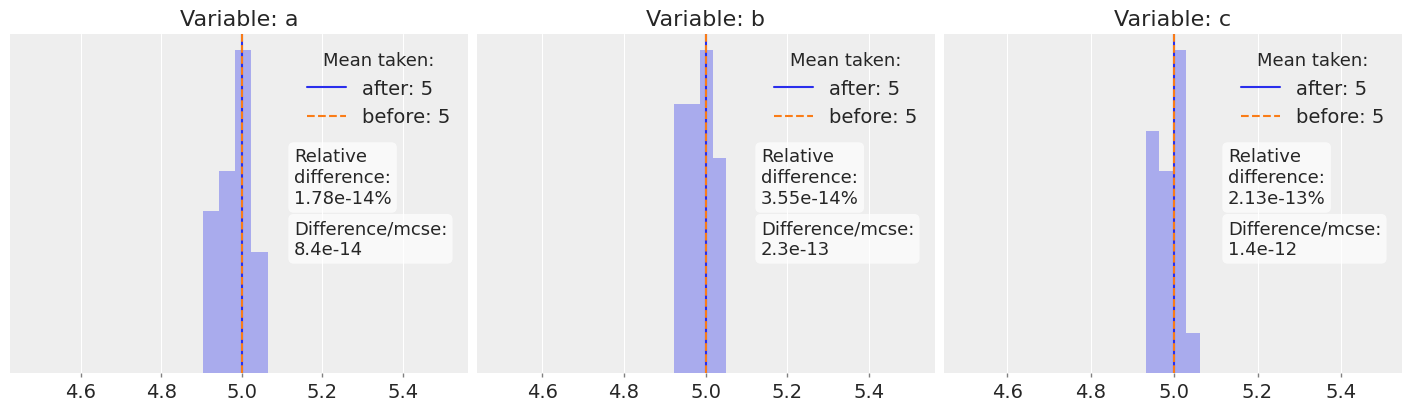

In [12]:
fun = lambda x, y: x+y

_, axes = plt.subplots(1, 3, figsize=(14, 4))
for i, var_name in enumerate("abc"):
    plot_func_comparison(fun, var_name, ax=axes[i])

The second example is a product between our two variables. This is no longer a linear operation and we can see noticeable differences in the result of distribution `a`. However, the dashed orange line is still only 3.7 MCSE units away from the real average and inside the region of the histogram. That means that it is still a credible value for the mean of the product.

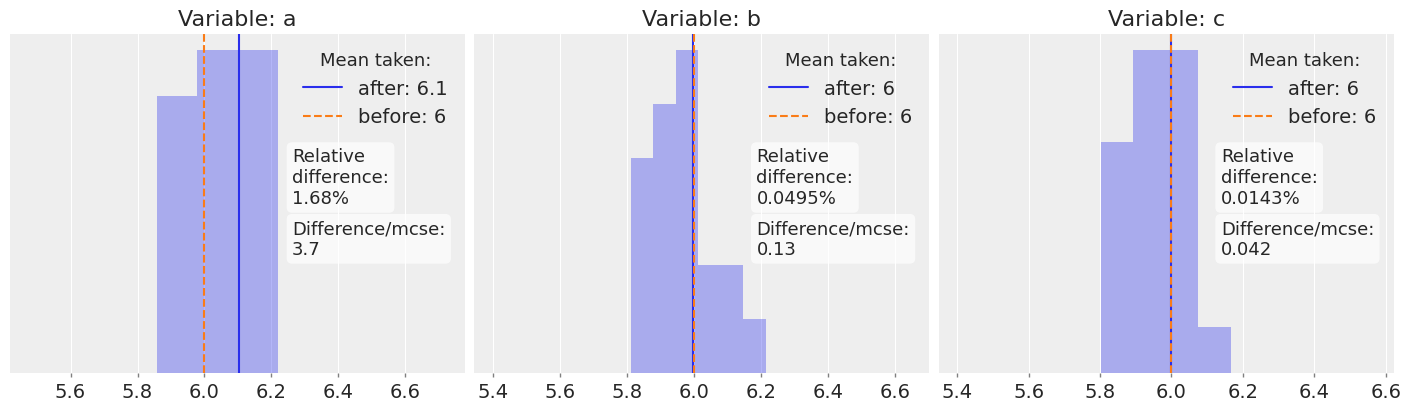

In [13]:
fun = lambda x, y: x*y

_, axes = plt.subplots(1, 3, figsize=(14, 4))
for i, var_name in enumerate("abc"):
    plot_func_comparison(fun, var_name, ax=axes[i])

The 3rd example is a division between the two variables. Here we see that the dashed orange line lies always outside the histogram range and over 9 MCSE units away from the real average. These values are no longer credible as the mean of the quotient!

If we plotted the distribution of quotient values, the dashed orange line would most probably still be on a high probability region, after all the relative difference is not too big. However, plausible **values** of the quotient and plausible **means** of the quotient are very different concepts that should not be confused. 

I am currently working on MCSE for arbitrary quantities and arbitrary summary statistics and on some recommendations related to its use. Hopefully I'll be able to write more on this.

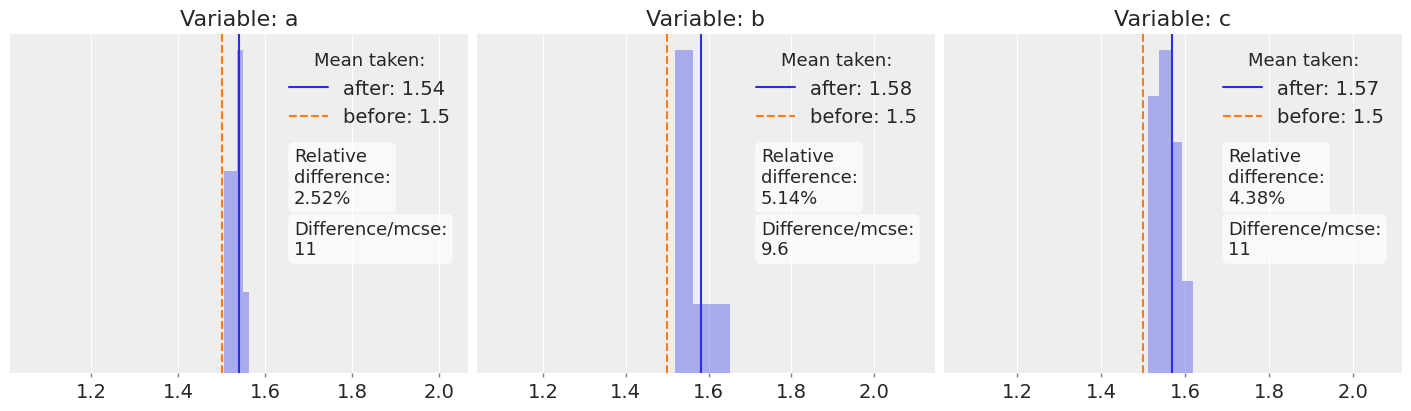

In [14]:
fun = lambda x, y: y/x

_, axes = plt.subplots(1, 3, figsize=(14, 4))
for i, var_name in enumerate("abc"):
    plot_func_comparison(fun, var_name, ax=axes[i])

Moreover, we can always find pathological cases:

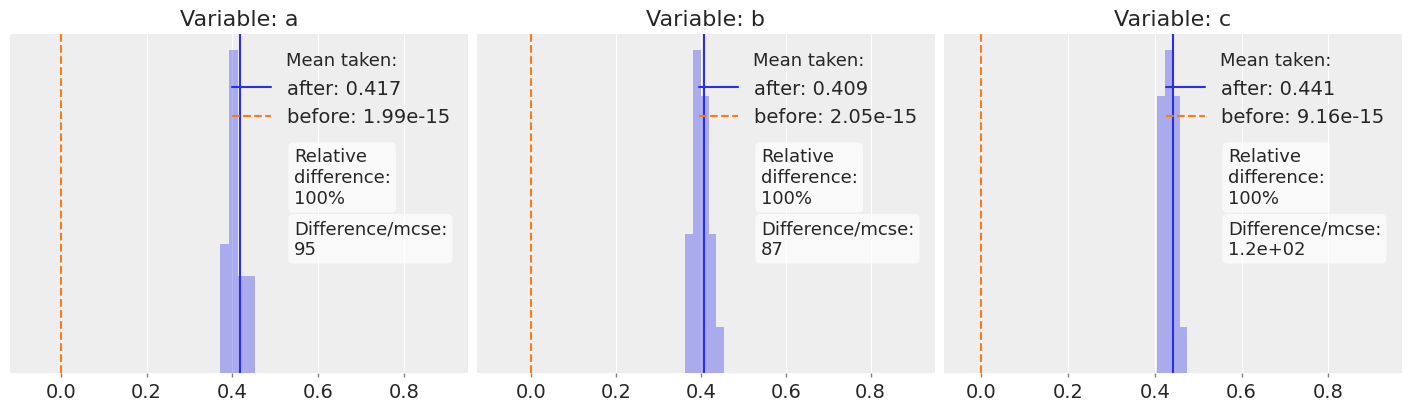

In [15]:
fun = lambda x, y: np.sqrt((x-2)**2 + (y-3)**2)

_, axes = plt.subplots(1, 3, figsize=(14, 4))
for i, var_name in enumerate("abc"):
    plot_func_comparison(fun, var_name, ax=axes[i])

### Golf putting example
I will also use the code from the [golf putting case study](https://docs.pymc.io/projects/examples/en/latest/case_studies/putting_workflow.html) (from PyMC examples because it already uses xarray). To illustrate two more points. 

The first is that averaging before operating is also dangerous when having a single variable: $E[f(x)] \neq f(E[x])$ (except for [linear functions](https://en.wikipedia.org/wiki/Expected_value#Properties) as we have seen).

And the second is that the "badness" of averaging before operating depends as we have seen on the distribution, on the function and can also depend on other constant inputs of the function. In this case, the effect of averaging before gets worse as we compute the pushforward operation on larger distances (we are modeling probabilities of making the putt as a function of the distance).

In [16]:
from xarray_einstats.stats import XrContinuousRV
import scipy.stats as st

BALL_RADIUS = (1.68 / 2) / 12
CUP_RADIUS = (4.25 / 2) / 12
OVERSHOT = 1.0
DISTANCE_TOLERANCE = 3.0

def forward_angle_model(variances_of_shot, t):
    norm_dist = XrContinuousRV(st.norm, 0, variances_of_shot)
    return 2 * norm_dist.cdf(np.arcsin((CUP_RADIUS - BALL_RADIUS) / t)) - 1

def forward_distance_angle_model(variance_of_shot, variance_of_distance, t):
    rv = XrContinuousRV(st.norm, 0, 1)
    angle_prob = 2 * rv.cdf(np.arcsin((CUP_RADIUS - BALL_RADIUS) / t) / variance_of_shot) - 1

    distance_prob_one = rv.cdf(
        (DISTANCE_TOLERANCE - OVERSHOT) / ((t + OVERSHOT) * variance_of_distance)
    )
    distance_prob_two = rv.cdf(-OVERSHOT / ((t + OVERSHOT) * variance_of_distance))
    distance_prob = distance_prob_one - distance_prob_two

    return angle_prob * distance_prob

Plotting code collapsed below:

In [17]:
#collapse-hide
def plot_golf_comparison(pushforward_func, var_name, t, ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 2, figsize=(12, 4))

    if isinstance(t, np.ndarray):
        t = xr.DataArray(t, dims=["distance"], coords={"distance": t})

    if pushforward_func == "angle":
        aux = post[var_name]
        post_after = forward_angle_model(aux.sel(var="shot"), t)
        aux = post_summary[var_name]
        summary_before = forward_angle_model(aux.sel(var="shot"), t)
    else:
        aux = post[var_name]
        post_after = forward_distance_angle_model(aux.sel(var="shot"), aux.sel(var="distance"), t)
        aux = post_summary[var_name]
        summary_before = forward_distance_angle_model(
            aux.sel(var="shot"), aux.sel(var="distance"), t
        )
    if summary == "mean":
        summary_after = post_after.mean(("chain", "draw"))
    else:
        summary_after = post_after.median(("chain", "draw"))

    ax_ = ax[0]
    summary_after.plot.line(marker=".", ls="none", color="C0", ax=ax_, label="after")
    summary_before.plot.line(marker=".", color="C1", ls="none", ax=ax_, label="before")
    ax_.legend(title="Mean taken:")
    ax_.set_ylabel("Probability of\nmaking the putt")
    ax_.set_title(f"Variable: {var_name}")

    ax_ = ax[1]
    (np.abs(summary_after - summary_before) / summary_after * 100).plot.line(marker=".", color="C0", ls="none", ax=ax_)
    ax_.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=1))
    ax_.set_title("Relative difference")

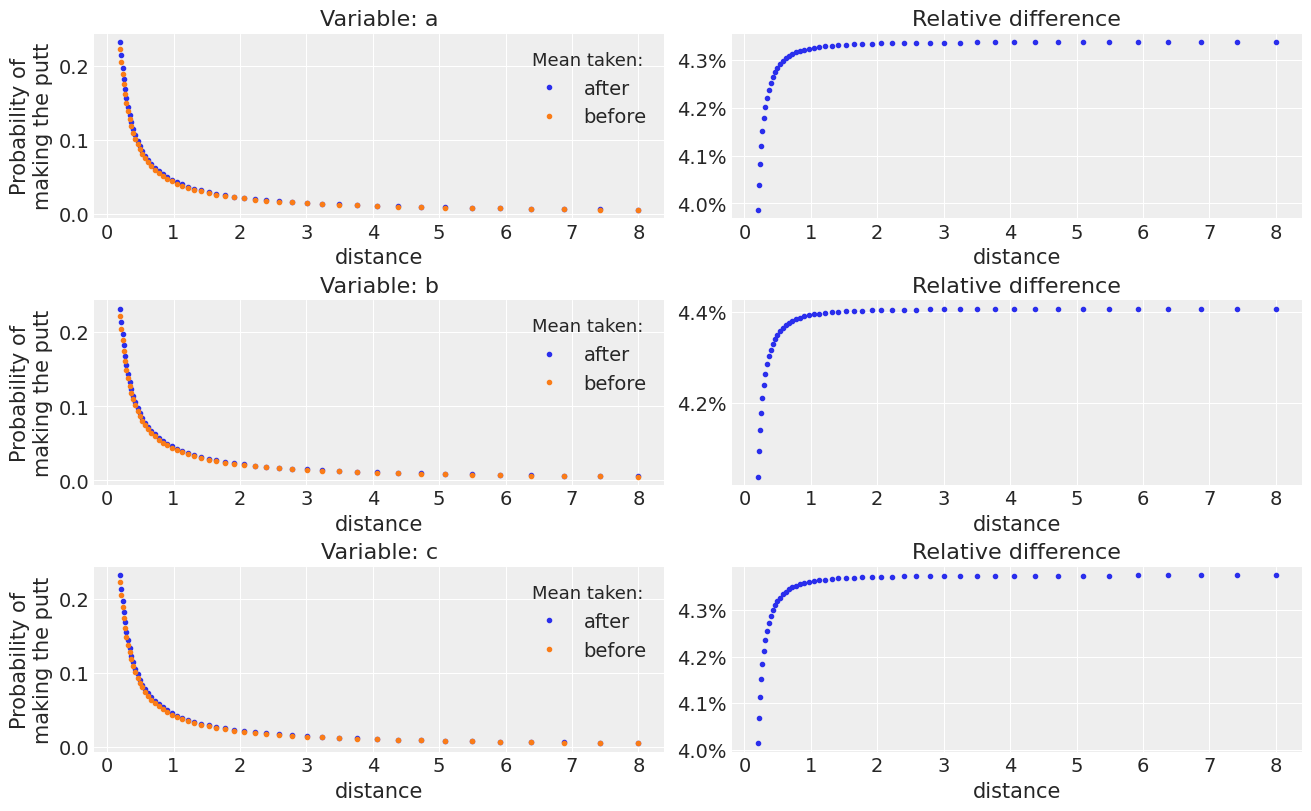

In [18]:
_, axes = plt.subplots(3, 2, figsize=(13, 8), constrained_layout=True)
t = np.geomspace(.2, 8)

for i, var_name in enumerate("abc"):
    plot_golf_comparison("angle", var_name, t=t, ax=axes[i, :])

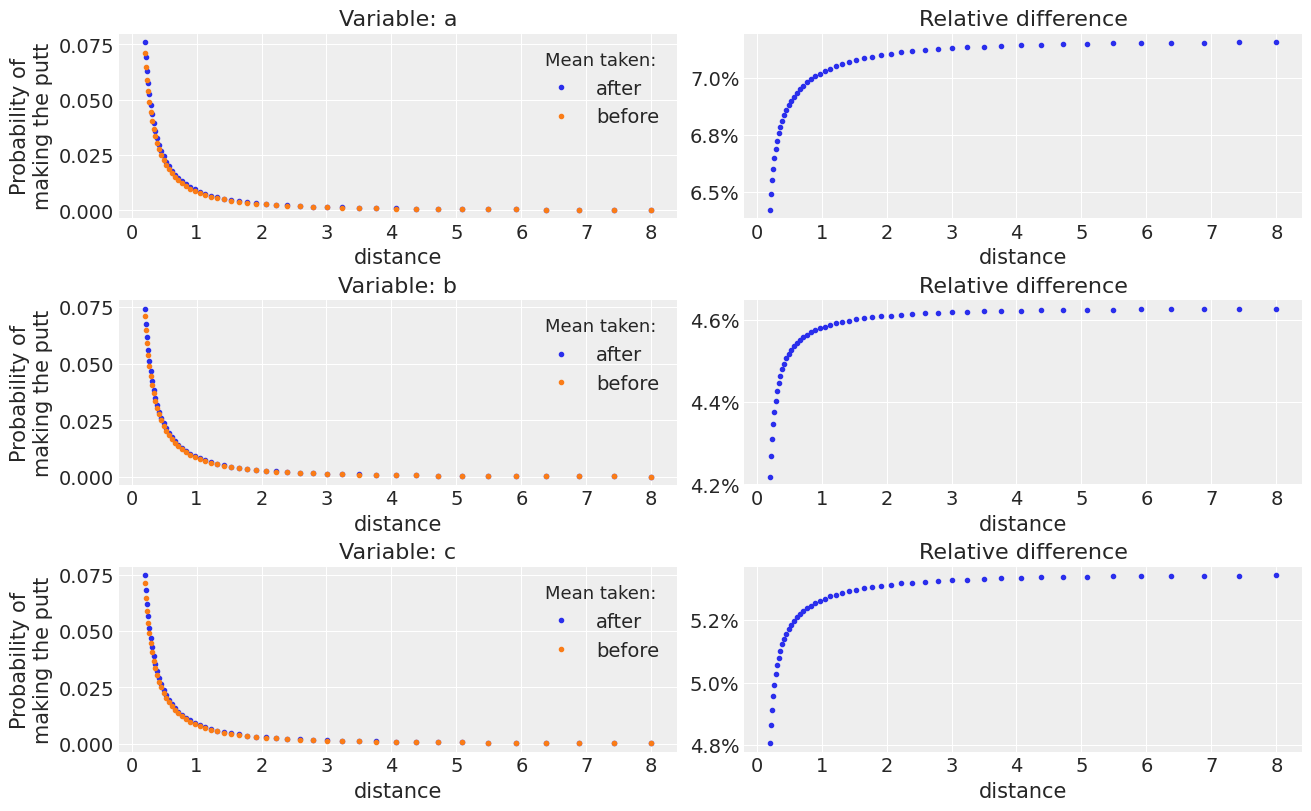

In [19]:
_, axes = plt.subplots(3, 2, figsize=(13, 8), constrained_layout=True)

for i, var_name in enumerate("abc"):
    plot_golf_comparison("distance_angle", var_name, t=t, ax=axes[i, :])

### A possible solution
I know the fact that all posterior samples should be used is not a secret in any sense, it is mostly the challenge of working comfortably with them that motivates computing summary statistics earlier than one should. The Bayesian workflow paper (Gelman et al 2020) mentions this as one of the open challenges in using Bayesian workflow in practice:

> Probabilistic programming ultimately has the potential to allow random variables to manipulated like any other data objects, with uncertainty implicit in all the plots and calculations, but much more work needs to be done to turn this possibility into reality, going beyond point and interval estimation so that we can make full use of the models we fit.

And while it is true it can still be challenging, batching operations is becoming increasingly simple and performant in Python, Julia or R and label based multidimensional arrays are also becoming more popular and applicable to a wide set of domains and tasks. I find that working with label based arrays and indexing operations is much more clear (both to others and to future me).

You can use [ArviZ](https://python.arviz.org) which builds on top of [xarray](https://docs.xarray.dev/en/stable/) and [xarray-einstats](https://einstats.python.arviz.org) to make all these computations while preserving the chain and draw dimensions in order to average later. The xarray ecosystem is developing and maturing quickly, you can already take advantage of automatic alignment and broadcasting for general python or math operations, for linear algebra, statistical operations like evaluation of pdf/cdf... or drawing from a specified distribution, fast fourier transforms...

As you'll have seen, this is what I am using in this post because I am the most comfortable working with Python and xarray, but the posterior R package recently introduced an [rvar](https://mc-stan.org/posterior/articles/rvar.html) type with similar properties for example, and similar work is also happening in the Julia ecosystem.

## Univariate priors
I recently collaborated a little to a [paper on prior elicitation](https://arxiv.org/abs/2112.01380), where the current state and future research possibilities are discussed. One of the challenges mentioned is that most of the work so far has been done on eliciting the univariate marginal prior distributions. But what we really need to elicit are multivariate prior distributions because it is the joint prior what afects the model and the sampling.

This section won't have (yet) a possible solution section at the end :sweat_smile:. I realize that univariate priors are the default and that we need to develop better tools before this can actually change in practice. But I think it is still good to be aware of its limitations. I will use an extreme example to show some of its limitations. Hopefully this will motivate more thorough prior and prior predictive checks.

I will use the [updating priors](https://docs.pymc.io/projects/examples/en/latest/pymc3_howto/updating_priors.html) notebook in the PyMC examples collection. It is a very popular example, there are often questions on discourse about adapting it to the specific situations of new users; and for good reason. It promises the philosophal stone of Bayesian statistics: using an old posterior as prior when we get new data so we can update our beliefs after seeing this new data and get an updated posterior. Again, this is very tempting, maybe even more so than premature averaging. But again, this is usually a bad idea, and more often than not a terrible one.

Let's see why.

In case you haven't gone through the linked notebook, the idea is the following:

1. Fit the model on the available data
2. Convert the posterior obtained into a prior using a KDE approximation
3. Get new data and fit the model using the generated prior
4. Repeat 2-3 every time new data becomes available

Here is the function used to take care of step 2:

In [20]:
def from_posterior(var_name, samples):
    smin, smax = np.min(samples), np.max(samples)
    width = smax - smin
    x = np.linspace(smin, smax, 100)
    y = st.gaussian_kde(samples)(x)

    # what was never sampled should have a small probability but not 0,
    # so we'll extend the domain and use linear approximation of density on it
    x = np.concatenate([[x[0] - 3 * width], x, [x[-1] + 3 * width]])
    y = np.concatenate([[0], y, [0]])
    return pm.Interpolated(var_name, x, y)

As usual, the devil lies in the details, there are two issues to take into account.

First and foremost, _this generates univariate priors_. The fit generated a _joint posterior_ and variables will probably not be independent between them. Therefore, any prior generated as a product of univariate distributions won't generally be able to represent the posterior.

Secondly and not so relevant, the KDE is also an approximation which might not be very accurate, especially when it comes to the tails. This `from_posterior` already contains a handmade correction to account for the tails being longer than the observed data, which is somewhat sensible but it also is clearly different from the actual tails we'd expect our distributions to have.

(This extension of the tails is done with the two `concatenate` lines, you can try comenting them if you download the notebook. If you do, you'll see better prior checks, but you will also be constraining all prior and posterior samples to have values between the minimum of the maximum in the distribution used to interpolate)

The bad news is that there really isn't anything you can do about this. There are some 2d KDE approximations available, but that will generally not be enough either to represent the posterior (as it will be more than 2d) and they are even less reliable than 1d KDEs.

We can use prior sampling to get an idea of the differences between the posteriors and the priors generated by this method by using our 3 simulated cases as posteriors.

In [21]:
#collapse-hide
def plot_prior_comparison(idata_prior, var_name, scatter=True, ax=None):
    kws = dict(
        contour_kwargs={"colors": "k"},
        contourf_kwargs={"alpha": 0},
        hdi_probs=[.2, .4, .6, .8]
    )
    kind = ["scatter", "kde"] if scatter else "kde"
    axes = az.plot_pair(
        idata_prior, 
        var_names=[f"{var_name}_shot", f"{var_name}_distance"], 
        group="prior", 
        marginals=scatter,
        kind=kind, kde_kwargs=kws,
        ax=ax
    );
    kws["contour_kwargs"]["colors"] = "r"
    az.plot_pair(
        idata, 
        var_names=var_name, coords={"var": ["shot", "distance"]},
        kind="kde", kde_kwargs=kws,
        ax=axes[1,0] if scatter else axes
    );
    if not scatter:
        axes.legend(handles=[
            mlines.Line2D([], [], color="k", label="KDE approximation"),
            mlines.Line2D([], [], color="r", label="Original posterior"),
        ])
    return axes

def plot_priors(idata_prior, var_name, figsize=None):
    # Instantiate figure and grid
    widths = [6, 1, 6]
    heights = [1.4, 6]
    fig = plt.figure(figsize=figsize, constrained_layout=True)
    grid = plt.GridSpec(
        2,
        3,
        hspace=0.1,
        wspace=0.1,
        figure=fig,
        width_ratios=widths,
        height_ratios=heights,
    )
    # Set up main plot
    ax = fig.add_subplot(grid[1, 0])
    # Set up top KDE
    ax_hist_x = fig.add_subplot(grid[0, 0], sharex=ax)
    ax_hist_x.set_yticks([])
    # Set up right KDE
    ax_hist_y = fig.add_subplot(grid[1, 1], sharey=ax)
    ax_hist_y.set_xticks([])
    
    x = idata_prior.prior[f"{var_name}_shot"].values.flatten()
    y = idata_prior.prior[f"{var_name}_distance"].values.flatten()
    

    for val, ax_, rotate in ((x, ax_hist_x, False), (y, ax_hist_y, True)):
        az.plot_dist(val, rotated=rotate, ax=ax_)

    # Personalize axes
    ax_hist_x.tick_params(labelleft=False, labelbottom=False)
    ax_hist_y.tick_params(labelleft=False, labelbottom=False)
    
    ax_zoom = fig.add_subplot(grid[1, -1])
    ax_return = np.array([[ax_hist_x, None, None], [ax, ax_hist_y, ax_zoom]])
    
    plot_prior_comparison(idata_prior, var_name, scatter=True, ax=ax_return[:, :-1])
    plot_prior_comparison(idata_prior, var_name, scatter=False, ax=ax_zoom)
    return ax_return

In [22]:
with pm.Model():
    a_shot = from_posterior("a_shot", post["a"].sel(var="shot").values.flatten())
    a_distance = from_posterior("a_distance", post["a"].sel(var="distance").values.flatten())
    
    a_prior = pm.sample_prior_predictive(2000)

/home/oriol/Public/pymc/pymc/distributions/continuous.py:3704: RuntimeWarning: divide by zero encountered in double_scalars
  np.where(np.abs(pdf[index]) <= 1e-8, np.zeros(index.shape), (p - cdf[index]) / pdf[index]),


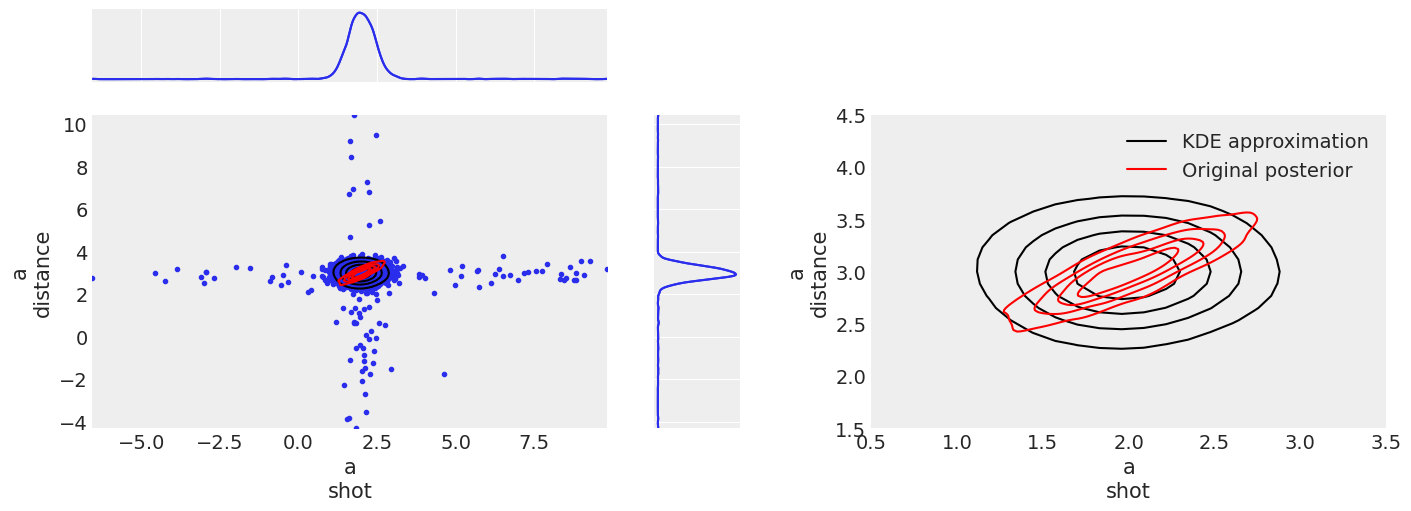

In [23]:
axes = plot_priors(a_prior, "a", figsize=(14, 5))
ax = axes[-1, -1]
ax.set_xlim((.5, 3.5))
ax.set_ylim((1.5, 4.5));

The figure on the left shows both the 2d distribution and the two marginals, and the one on the right shows only the 2d distribution zoomed in. All 2d KDEs (here and in coming posts) have 4 contour lines with the probability inside each line being `[.2, .4, .6, .8]` in order to allow proper comparison.

The figure on the left shows the problematic with the KDE approximation and the tail extension. The combination of the high probability central region with the low probability but not negligible tails generates this + looking shape. It is possible to have values outside this cross, and in this generation there is one on the lower right quadrant, but the probability of a draw being on the tail of the distribution is very low so the probability of this happening twice even for the two independent distributions is extremely low. We can see however how this tail expansion has no effect on the KDE lines, not even for the one that contains 80% of the probability, so even if their values are a bit too extreme, their probability is very low and generally not a source of worry.

The figure on the right shows clearly how our prior even if generated from interpolating our original (red) distribution is unable to retrieve the dependency between the two variables.

In [24]:
with pm.Model():
    b_shot = from_posterior("b_shot", post["b"].sel(var="shot").values.flatten())
    b_distance = from_posterior("b_distance", post["b"].sel(var="distance").values.flatten())
    
    b_prior = pm.sample_prior_predictive(2000)

/home/oriol/Public/pymc/pymc/distributions/continuous.py:3704: RuntimeWarning: divide by zero encountered in double_scalars
  np.where(np.abs(pdf[index]) <= 1e-8, np.zeros(index.shape), (p - cdf[index]) / pdf[index]),


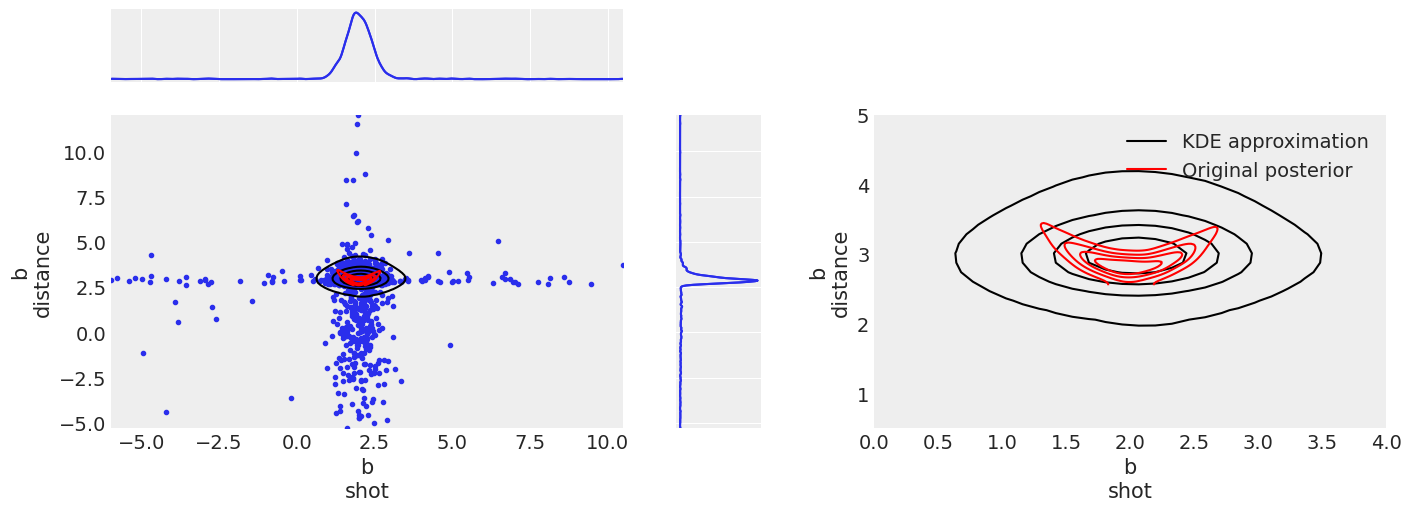

In [25]:
axes = plot_priors(b_prior, "b", figsize=(14, 5))
ax = axes[-1, -1]
ax.set_xlim((0, 4))
ax.set_ylim((.5, 5));

Here again, we see the same effects as we saw for distribution `a`. Even a bit more exagerated. Now the marginal distribution on the `distance` variable is not symettric, so the tail extension fares worse than before.

The shape of the dependency between variables is also more complicated now than it was in distribution `a`, so the isodensity regions differ even more from the original (red) distribution.

In [26]:
with pm.Model():
    c_shot = from_posterior("c_shot", post["c"].sel(var="shot").values.flatten())
    c_distance = from_posterior("c_distance", post["c"].sel(var="distance").values.flatten())
    
    c_prior = pm.sample_prior_predictive(2000)

/home/oriol/Public/pymc/pymc/distributions/continuous.py:3704: RuntimeWarning: divide by zero encountered in double_scalars
  np.where(np.abs(pdf[index]) <= 1e-8, np.zeros(index.shape), (p - cdf[index]) / pdf[index]),


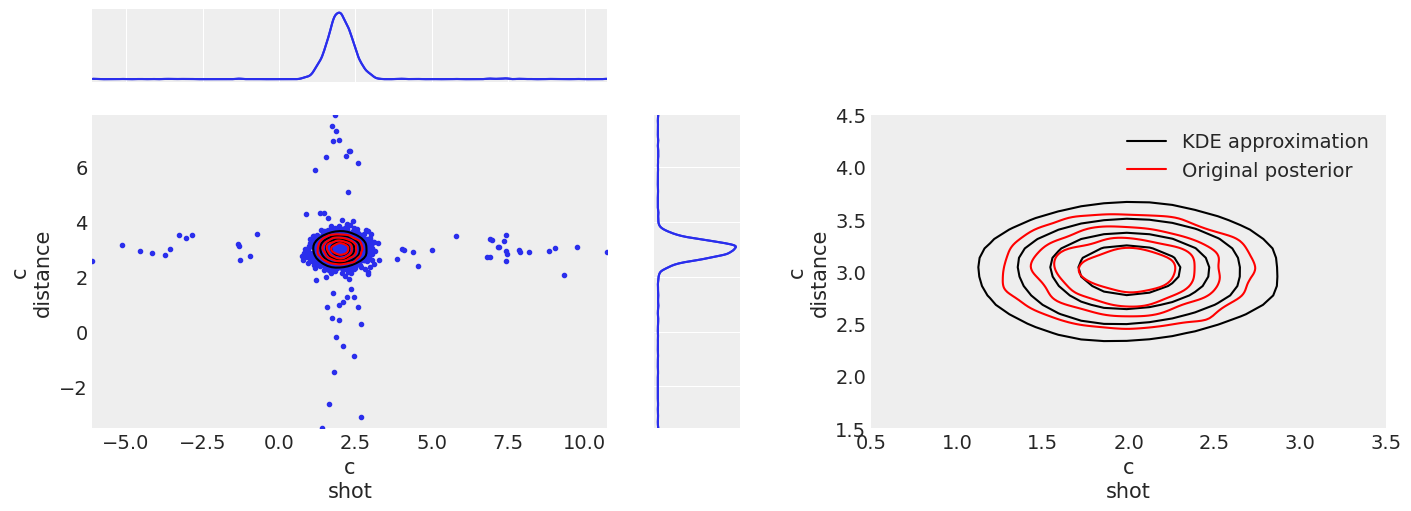

In [27]:
axes = plot_priors(c_prior, "c", figsize=(14, 5))
ax = axes[-1, -1]
ax.set_xlim((0.5, 3.5))
ax.set_ylim((1.5, 4.5));

The two variables in `c` are independent, so here the only source of error will be the KDE approximation and tail expansion. We see that indeed the shape of the posterior is now right, but the size is not exactly the same. Like in all other examples, the tails are overpopulated due to the tail extension.

Again, hopefully I'll be able to write about tools for multidimensional prior elicitation at some point :see_no_evil:.

Package versions used to generate this post:

In [28]:
#hide_input
%load_ext watermark
%watermark -n -u -v -iv -w -p xarray_einstats

Last updated: Thu May 19 2022

Python implementation: CPython
Python version       : 3.9.10
IPython version      : 8.3.0

xarray_einstats: 0.3.0.dev0

scipy     : 1.7.3
pymc      : 4.0.0b6
matplotlib: 3.5.1
arviz     : 0.13.0.dev0
numpy     : 1.21.5
xarray    : 2022.3.0

Watermark: 2.3.0



---
Comments are not enabled for this post, to inquiry further about the contents of the post, ask on [Stan Discourse](https://discourse.mc-stan.org/) or [PyMC Discourse](https://discourse.pymc.io/). Feel free to tag me at `@OriolAbril`